In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

In [86]:
df = pd.read_csv("institute_data.csv", encoding='latin1', on_bad_lines='skip')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21896\2597987364.py:1: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("institute_data.csv", encoding='latin1', on_bad_lines='skip')


In [87]:
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122996 entries, 0 to 122995
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                122995 non-null  float64
 1   nids                   122996 non-null  object 
 2   scholarship_name       122996 non-null  object 
 3   first_name             122985 non-null  object 
 4   last_name              110919 non-null  object 
 5   amount                 121943 non-null  object 
 6   year                   122994 non-null  object 
 7   gender                 122991 non-null  object 
 8   physically_challenged  119471 non-null  object 
 9   academic_class         122993 non-null  object 
 10  present_class          67806 non-null   object 
 11  institute_name         122904 non-null  object 
 12  board_name             41266 non-null   object 
 13  institute_address      10748 non-null   object 
 14  institute_district     111698 non-nu

In [89]:
# Cleaning
df['user_id'] = df['user_id'].astype('Int64')
df['amount'] = df['amount'].replace('[^\d.]', '', regex=True)  # remove symbols
df['amount'] = df['amount'].replace('', np.nan)                # replace empty string with NaN
df['amount'] = df['amount'].astype(float)                      # now safely convert to float

In [90]:
# Check for nulls
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing[missing > 0])

Missing values:
 institute_address        112248
board_name                81730
present_class             55190
last_name                 12077
institute_district        11298
institute_state            3766
physically_challenged      3525
amount                     1055
domicile_state              713
institute_name               92
first_name                   11
gender                        5
academic_class                3
year                          2
user_id                       1
dtype: int64


In [91]:
# Drop columns with too many nulls
drop_cols = ['institute_address', 'board_name', 'present_class']
df = df.drop(columns=drop_cols)

In [92]:
# Fill remaining nulls
df['last_name'].fillna('Unknown', inplace=True)
df['physically_challenged'].fillna('No', inplace=True)
df['gender'].fillna(df['gender'].mode()[0], inplace=True)
df['institute_name'].fillna('Unknown', inplace=True)

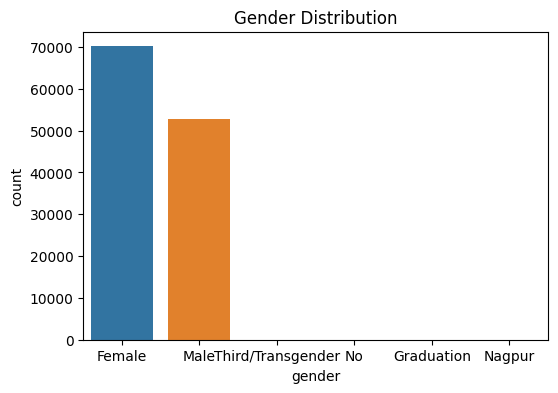

In [93]:
# EDA Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df)
plt.title("Gender Distribution")
plt.show()

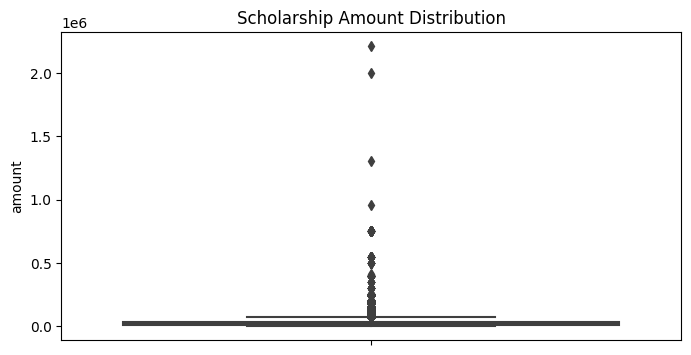

In [94]:
plt.figure(figsize=(8, 4))
sns.boxplot(y='amount', data=df)
plt.title("Scholarship Amount Distribution")
plt.show()

c:\Users\lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


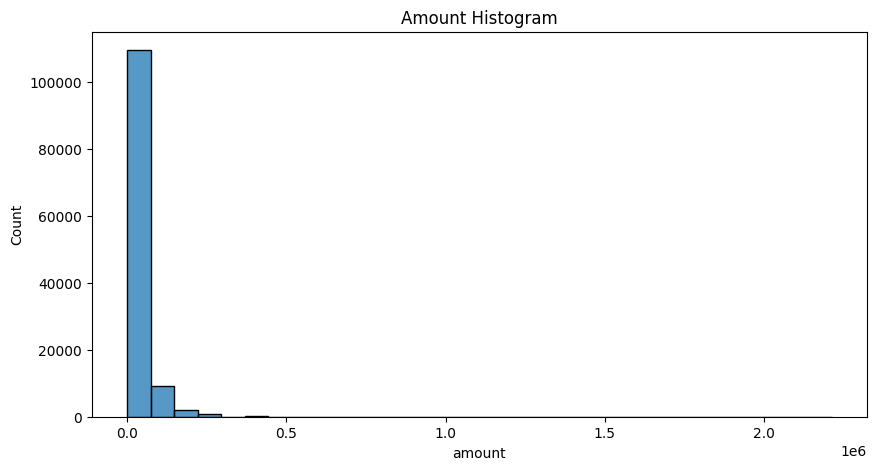

In [95]:
plt.figure(figsize=(10, 5))
sns.histplot(df['amount'], bins=30)
plt.title("Amount Histogram")
plt.show()

In [96]:
# ML Preparation: Predict if amount >= threshold (e.g., 10,000)
df['high_amount'] = (df['amount'] >= 10000).astype(int)

In [97]:
df.head()

,user_id,nids,scholarship_name,first_name,last_name,amount,year,gender,physically_challenged,academic_class,institute_name,institute_district,institute_state,domicile_state,high_amount
0,2,17993,Abdul Kalam Scholarship for Medical/Engineerin...,Manish,Singh,10.0,"2022,2024,2025",Female,No,Graduation,rajkiya inter college,Dwarka,Gujarat,Karnataka,0
1,80,16638,Keep India Smiling Foundational Scholarship Pr...,Praise,Paul,20000.0,2021,Male,No,Class 11,"St. Thomas PU College, Byndoor",Udupi,Karnataka,Karnataka,1
2,125,7962,Marubeni India Meritorious Scholarship 2016,Avick,Das,NaN,2017,Male,No,Graduation,Jhikra High School,NaN,NaN,West Bengal,0
3,355,7962,Marubeni India Meritorious Scholarship 2016,Nimmala,Vishnu,NaN,2017,Male,No,Graduation,SRI VAAGDEVI JUNIOR COLLEGE,NaN,NaN,Telangana,0
4,620,17159,LIC HFL Vidhyadhan Scholarship for Post-Gradua...,Chandra,Muneshwar,30000.0,2021,Male,Yes,Post Graduation,TATA INSTITUTE OF SOCIAL SCIENCES,Varanasi,Maharashtra,Bihar,1


In [98]:
# Select features
features = ['gender', 'physically_challenged', 'academic_class', 'year', 'domicile_state']
df_ml = df[features + ['high_amount']].dropna()

In [99]:
features

['gender', 'physically_challenged', 'academic_class', 'year', 'domicile_state']

In [100]:
df_ml

,gender,physically_challenged,academic_class,year,domicile_state,high_amount
0,Female,No,Graduation,"2022,2024,2025",Karnataka,0
1,Male,No,Class 11,2021,Karnataka,1
2,Male,No,Graduation,2017,West Bengal,0
3,Male,No,Graduation,2017,Telangana,0
4,Male,Yes,Post Graduation,2021,Bihar,1
...,...,...,...,...,...,...
122991,Male,No,Graduation,2025,Karnataka,1
122992,Female,No,Graduation,2025,Karnataka,1
122993,Female,No,Class 2,2025,Maharashtra,1
122994,Male,No,Class 11,2025,Maharashtra,1


In [101]:
# Encoding categorical features
df_ml_encoded = pd.get_dummies(df_ml, drop_first=True)

In [102]:
df_ml_encoded

,high_amount,gender_Male,gender_Third/Transgender,physically_challenged_Yes,academic_class_Class 10,academic_class_Class 11,academic_class_Class 12,academic_class_Class 12 Passed,academic_class_Class 2,academic_class_Class 3,...,domicile_state_Punjab,domicile_state_Rajasthan,domicile_state_Sikkim,domicile_state_Sudurpashchim,domicile_state_Tamil Nadu,domicile_state_Telangana,domicile_state_Tripura,domicile_state_Uttar Pradesh,domicile_state_Uttarakhand,domicile_state_West Bengal
0,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,1,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122991,1,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
122992,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
122993,1,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
122994,1,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [107]:
# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8840004906570716
              precision    recall  f1-score   support

           0       0.72      0.43      0.54      3857
           1       0.90      0.97      0.93     20600

    accuracy                           0.88     24457
   macro avg       0.81      0.70      0.74     24457
weighted avg       0.87      0.88      0.87     24457



In [109]:
# Save model
import joblib
joblib.dump(model, "scholarship_model.pkl")
joblib.dump(X.columns, "model_features.pkl")

['model_features.pkl']